In [1]:
# Cell 1: imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import seaborn as sns

In [2]:
# Cell 2: load sample
df = pd.read_csv("data/play_store_raw/safari_reviews_sample.csv", parse_dates=['review_date'])

In [3]:
# Cell 3: basic stats
print("Total reviews:", len(df))
print("Rating distribution:\n", df['rating'].value_counts().sort_index())

Total reviews: 61
Rating distribution:
 rating
1     8
2     4
3     2
4     7
5    40
Name: count, dtype: int64


# Sentiment Score

A sentiment score is a numerical representation of the emotional tone expressed in a piece of text,
derived from sentiment analysis, which uses natural language processing (NLP) and machine learning to 
classify text into positive, negative, or neutral sentiments.
 It quantifies the polarity and intensity of emotions, typically ranging from -100 to +100 (where 0 is neutral), 
-1 to +1 (with 0 as neutral), or as a percentage from 0% to 100%.
 The score is calculated by analyzing the frequency and context of positive and negative words, with modern systems
using AI models like large language models (LLMs) to detect nuances such as sarcasm, negation, and intensity.
 For example, a score close to +1 or +100 indicates strong positive sentiment, while a score near -1 or -100 signifies
strong negativity, and a score around 0 suggests neutrality

In [7]:
# Cell 4: add sentiment score
sid = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['review_text'].fillna('').apply(lambda t: sid.polarity_scores(str(t))['compound'])
df['sentiment_label'] = df['sentiment_score'].apply(lambda s: 'positive' if s>0.2 else ('negative' if s<-0.2 else 'neutral'))
df.groupby('sentiment_label').size()

sentiment_label
negative     3
neutral     11
positive    47
dtype: int64

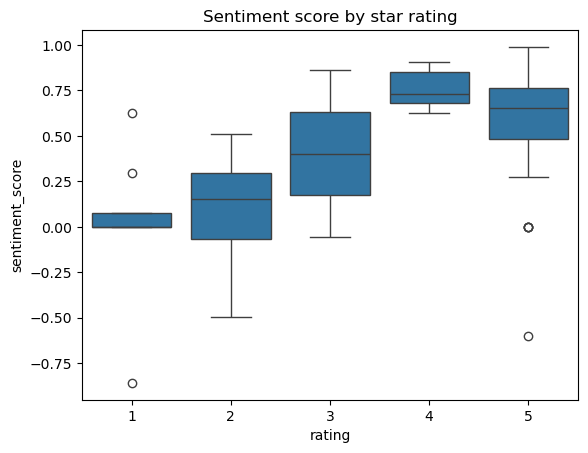

In [9]:
# Cell 5: sentiment by rating
sns.boxplot(x='rating', y='sentiment_score', data=df)
plt.title("Sentiment score by star rating")
plt.savefig("figures/sentiment_by_rating.png")
plt.show()

from the boxplots we can see that reviews are mostly positive with sentiments scores falling above 0 and -0.2

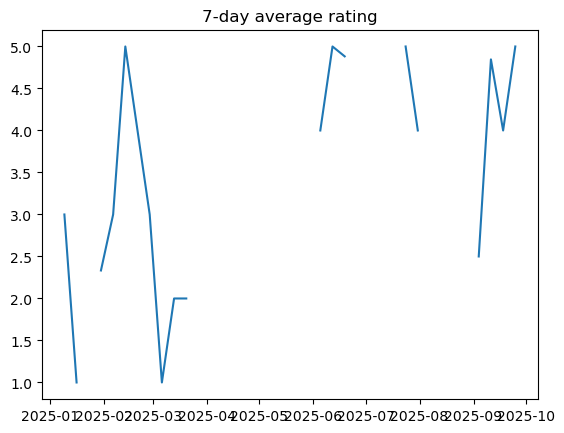

In [13]:
# Cell 6: date series - rolling avg of rating
daily = df.set_index('review_date').resample('7D').rating.mean().reset_index()
plt.plot(daily['review_date'], daily['rating'])
plt.title("7-day average rating")
plt.savefig("figures/avg_rating_time.png")
plt.show()

we can see that reviews were becoming increasing positive with --- dtae having a significant downward spike

In [15]:
# Cell 7: identify negative review topics (bigrams/trigrams)
neg = df[df['sentiment_label']=='negative'].copy()
vec = CountVectorizer(ngram_range=(1,2), stop_words='english')
X = vec.fit_transform(neg['review_text'].fillna(''))
sums = X.sum(axis=0)
terms = [(term, sums[0, idx]) for term, idx in vec.vocabulary_.items()]
top_terms = sorted(terms, key=lambda x: x[1], reverse=True)[:40]
pd.DataFrame(top_terms, columns=['term','count']).head(20)


,term,count
0,game,2
1,level,2
2,coins,2
3,just,2
4,nice,1
5,keeps,1
6,freezing,1
7,annoying,1
8,nice game,1
9,game keeps,1


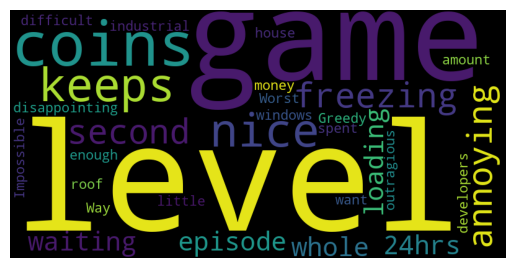

In [16]:

# Cell 8: wordcloud for negative reviews
wc = WordCloud(width=800, height=400).generate(' '.join(neg['review_text'].astype(str)))
plt.imshow(wc)
plt.axis('off')
plt.savefig("figures/wordcloud_negative.png")
plt.show()

why is level mentioned so frequently? what abiut annoying? freezing?

In [18]:
# Cell 9: pre/post update test
cutoff = pd.to_datetime("2025-09-04")  # update date from Play Store
before = df[df['review_date'] < cutoff]
after = df[df['review_date'] >= cutoff]
print("Avg rating before:", before['rating'].mean())
print("Avg rating after:", after['rating'].mean())
# quick t-test or non-param test
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(before['rating'].dropna(), after['rating'].dropna(), alternative='two-sided')
print("Mann-Whitney p-value:", p)

Avg rating before: 3.9318181818181817
Avg rating after: 4.529411764705882
Mann-Whitney p-value: 0.3559069407732146


The p-value in a Mann-Whitney U test represents the probability of observing a test statistic at least as extreme as the one
calculated from the sample data, assuming the null hypothesis is true.
 The null hypothesis states that the two populations have identical distributions, meaning there is a 50% chance that a randomly 
selected observation from one population will be greater than a 
randomly selected observation from the other population.
 A small p-value (typically ≤ 0.05) provides strong evidence against the null hypothesis, leading to its rejection and indicating 
that the two populations likely differ in their median values.
 Conversely, a large p-value (greater than the chosen significance level, often 0.05) means there is insufficient evidence to reject 
the null hypothesis, suggesting the observed difference could be due to random sampling variation.

P.S - you can reach out to me for a detailed explanation of this analysis. 
    Thank you!